In [1]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import datetime
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [2]:
from src.model.modelGranoGan import Encoder,Decoder,Critic
from src.utils.losses import Wasserstein
from src.utils.util import *
from src.dataset.wadi import WadiDataset
from src.algorithms.GranoGAN import GranoGAN

In [3]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
    


22:46:34


<h4>Initializing Dataset</h4>

In [4]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=5
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)


class Datasettings:
    
    def __init__(self):
        self.dataset_training_name="/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_14days.csv"
        self.dataset_test_name="/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_attackdata.csv"
        self.dataset_anomaly_name="/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_anomalies.csv"
        self.train=True
        self.window_length=60

In [5]:
seed=0
data_settings = Datasettings()
wadi = WadiDataset(seed,data_settings)

In [6]:
x_train, y_train, x_test, y_test = wadi.data()

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_14days.csv'

In [13]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x_train)
x_train = imputer.transform(x_train)

In [14]:
reduced_dimesnion=3
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_train)
x_train=pca.transform(x_train)

In [15]:
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_test)
x_test=pca.transform(x_test)

In [16]:
sequences,y_train_per_window = get_sub_seqs(x_train,y_train, seq_len=60, stride=1,
                                 start_discont=np.array([]))

In [17]:
train_loader, train_val_loader = get_train_data_loaders(sequences, batch_size=opt_trn.batch_size,
                                                                splits=[1 - 0.2,
                                                                        0.2], seed=0)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = wadi.window_length # sequence length is equal to the window length
in_dim = reduced_dimesnion # input dimension is same as number of feature
n_features=reduced_dimesnion


In [19]:

import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())


__Python VERSION: 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05) 
[GCC 9.3.0]
__pyTorch VERSION: 1.10.0a0+3fd9dcf
__CUDA VERSION
/bin/bash: /libraries/Default_env_55760/lib/libtinfo.so.6: no version information available (required by /bin/bash)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Wed_Jul_14_19:41:19_PDT_2021
Cuda compilation tools, release 11.4, V11.4.100
Build cuda_11.4.r11.4/compiler.30188945_0
__CUDNN VERSION: 8202
__Number CUDA Devices: 2
__Devices
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Tesla T4, 450.172.01, 15109 MiB, 1268 MiB, 13841 MiB
1, Tesla T4, 450.172.01, 15109 MiB, 1244 MiB, 13865 MiB
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


In [20]:
granoGAN=GranoGAN(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,in_dim=in_dim)

<h4>CriticX training</h4>

In [ ]:
criticX=granoGAN.train_criticX(train_loader)

/home/jupyter/src/algorithms/GranoGAN.py:110: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=self.mean,std=self.std))


Epoch 0: train loss -1.9283161091780456


In [21]:
PATH='/home/jupyter/GRANOGAN-IISC/src/saved_models/granogan/wadi/criticX.pkl'


In [ ]:
torch.save(criticX.module.state_dict(), PATH)

In [22]:
criticX=Critic(in_dim=in_dim,device=device)
criticX=nn.DataParallel(criticX)
criticX.to(device)
state_dict = torch.load(PATH)
criticX=granoGAN.load_model(state_dict,criticX)

In [23]:
granoGAN.initialize_criticX(criticX)

<h4>CriticZ training</h4>

In [ ]:
criticZ=granoGAN.train_criticZ(train_loader)

In [24]:
PATH='/home/jupyter/GRANOGAN-IISC/src/saved_models/granogan/wadi/criticZ.pkl'


In [ ]:
torch.save(criticZ.module.state_dict(), PATH)

In [25]:
criticZ=Critic(in_dim=in_dim,device=device)
criticZ=nn.DataParallel(criticZ)
criticZ.to(device)
state_dict = torch.load(PATH)
criticZ=granoGAN.load_model(state_dict,criticZ)

In [26]:
granoGAN.initialize_criticZ(criticZ)

<h4>Encoder and Decoder training</h4>

In [ ]:
encoder,decoder=granoGAN.train_enc_dec(train_loader)

In [27]:
PATH_encoder='/home/jupyter/GRANOGAN-IISC/src/saved_models/granogan/wadi/encoder.pkl'

PATH_decoder='/home/jupyter/GRANOGAN-IISC/src/saved_models/granogan/wadi/decoder.pkl'


In [ ]:
torch.save(encoder.module.state_dict(), PATH_encoder)
torch.save(decoder.module.state_dict(), PATH_decoder)

In [28]:
encoder=Encoder(n_features=in_dim, embedding_dim=in_dim,device=device)
encoder=nn.DataParallel(encoder)
encoder.to(device)
state_dict = torch.load(PATH_encoder)
encoder=granoGAN.load_model(state_dict,encoder)

In [29]:
decoder=Decoder(in_dim=in_dim,out_dim=in_dim,device=device)
decoder=nn.DataParallel(decoder)
decoder.to(device)
state_dict = torch.load(PATH_decoder)
decoder=granoGAN.load_model(state_dict,decoder)

In [30]:
granoGAN.initialize_decoder(decoder)
granoGAN.initialize_encoder(encoder)

<h4>Loading back saved models</h4>

In [ ]:
granoGAN.initialize_models(criticX,criticZ,decoder,encoder)

<h2>Testing for anomaly</h2>

In [31]:
sequences,y_test_per_window = get_sub_seqs(x_test,y_test, seq_len=60, stride=60, start_discont=np.array([]))
test_loader = DataLoader(dataset=sequences, batch_size=1,  num_workers=4,
                                 shuffle=False)

In [32]:
losses=granoGAN.predict_loss(test_loader)

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

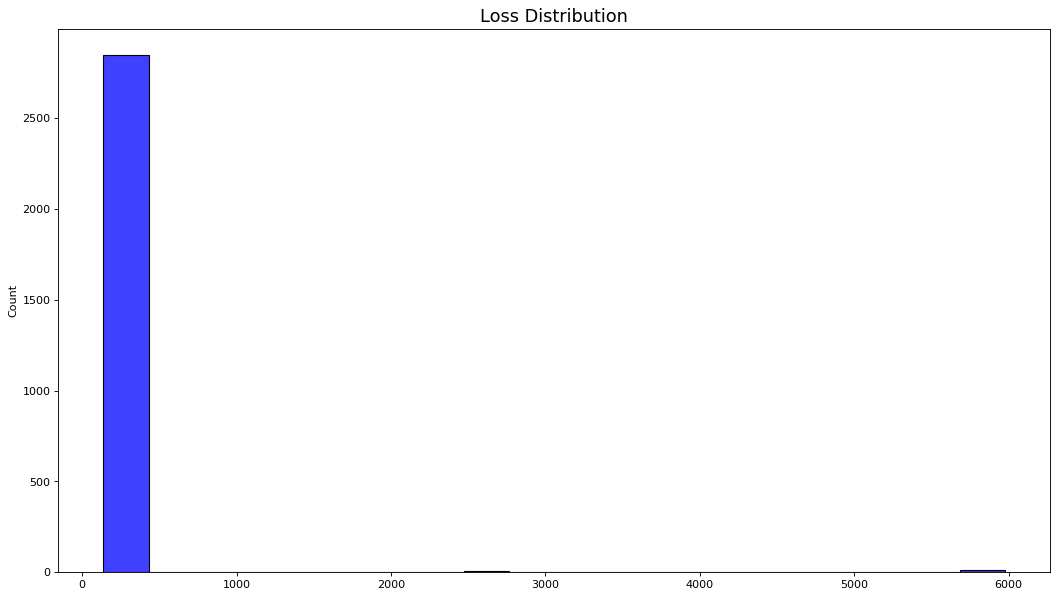

In [34]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(losses, bins = 20, kde= False, color = 'blue');
#sns.distplot(losses, bins = 20, kde= True, color = 'blue');

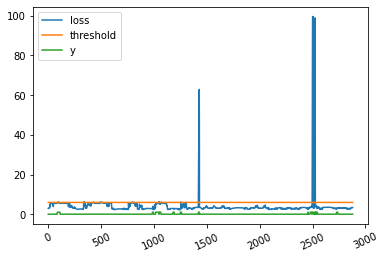

In [35]:
THRESHOLD =5.931

test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss/60 for loss in losses]
test_score_df['y'] = y_test_per_window
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
#test_score_df['t'] = [x[59].item() for x in sequences]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();


In [36]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

In [37]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 112
True Negative	 2665
False Positive	 37
False Negative	 66
Accuracy	 0.9642361111111111
Precision	 0.7516778523489933
Recall	 0.6292134831460674
f-measure	 0.6850152905198776
cohen_kappa_score	 0.6662150788328329
auc	 0.8077599614101914
roc_auc	 0.8077599614101914
